In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchaudio.transforms import MelSpectrogram

from utility.data_loader import EmotionDataset
from utility.models import VideoCNN, AudioCNN
from utility.fusion import LateFusion

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Training Model Starts Here

In [2]:
root_dir = 'data/train' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((112, 112)), #resize should happen before ToTensor.
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

audio_transform = MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=512, n_mels=64)

dataset = EmotionDataset(root_dir, transform=transform, audio_transform=audio_transform)
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

cuda
142


In [3]:
video_model = VideoCNN(num_classes=2).to(device)
audio_model = AudioCNN(num_classes=2).to(device)
fusion_model = LateFusion(num_classes=2, fusion_type='mlp').to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    list(video_model.parameters()) +
    list(audio_model.parameters()) +
    list(fusion_model.parameters()),
    lr=1e-4
)

# training
num_epochs = 20
# num_epochs = 15
for epoch in range(num_epochs):
    video_model.train()
    audio_model.train()
    fusion_model.train()

    total_loss = 0
    correct = 0
    total = 0

    for spectrograms, frames, labels in dataloader:
        spectrograms = spectrograms.to(device)
        frames = frames.to(device)
        
        # label values
        # print("Batch label values:", labels)
        # print("Unique:", labels.unique())

        labels = labels.long().to(device)  # Ensure correct type

        optimizer.zero_grad()

        video_logits = video_model(frames)           
        audio_logits = audio_model(spectrograms)     
        fused_logits = fusion_model(video_logits, audio_logits)  

        loss = criterion(fused_logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(fused_logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f} | Acc: {acc:.2f}%")

C:\Users\ericw\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ericw\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\ericw\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 1/20 | Loss: 4.4242 | Acc: 53.52%
Epoch 2/20 | Loss: 6.1909 | Acc: 60.56%
Epoch 3/20 | Loss: 3.2404 | Acc: 65.49%
Epoch 4/20 | Loss: 3.1554 | Acc: 74.65%
Epoch 5/20 | Loss: 2.4696 | Acc: 83.10%
Epoch 6/20 | Loss: 1.9154 | Acc: 85.92%
Epoch 7/20 | Loss: 1.9527 | Acc: 87.32%
Epoch 8/20 | Loss: 2.2239 | Acc: 85.92%
Epoch 9/20 | Loss: 1.4211 | Acc: 88.73%
Epoch 10/20 | Loss: 2.8176 | Acc: 91.55%
Epoch 11/20 | Loss: 1.8596 | Acc: 91.55%
Epoch 12/20 | Loss: 0.9675 | Acc: 95.77%
Epoch 13/20 | Loss: 0.9871 | Acc: 96.48%
Epoch 14/20 | Loss: 1.0039 | Acc: 93.66%
Epoch 15/20 | Loss: 0.9832 | Acc: 93.66%
Epoch 16/20 | Loss: 0.7305 | Acc: 94.37%
Epoch 17/20 | Loss: 0.6264 | Acc: 95.77%
Epoch 18/20 | Loss: 0.4780 | Acc: 97.89%
Epoch 19/20 | Loss: 0.8965 | Acc: 95.07%
Epoch 20/20 | Loss: 0.8646 | Acc: 95.77%


In [4]:
torch.save({
    'video_model': video_model.state_dict(),
    'audio_model': audio_model.state_dict(),
    'fusion_model': fusion_model.state_dict()
}, "rage_detection_fusion_train.pt")

In [5]:
def evaluate_model(video_model, audio_model, fusion_model, dataloader, device):
    video_model.eval()
    audio_model.eval()
    fusion_model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for spectrograms, frames, labels in dataloader:
            spectrograms = spectrograms.to(device)
            frames = frames.to(device)
            labels = labels.to(device)

            video_logits = video_model(frames)
            audio_logits = audio_model(spectrograms)
            fused_logits = fusion_model(video_logits, audio_logits)

            predictions = torch.argmax(fused_logits, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n Evaluation Metrics:")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1-score     : {f1:.4f}")

    # plot the confusion matrix
    class_names = ["Rage", "Not Rage"]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    print("Evaluation metrics with both classses:")
    print(classification_report(y_true, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

In [6]:
# Evaluate on training data (not really necessary)
# evaluate_model(video_model, audio_model, fusion_model, dataloader, device)

# Testing Model Starts Here

In [7]:
root_dir = 'data/test' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((112, 112)), #resize should happen before ToTensor.
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

audio_transform = MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=512, n_mels=64)

dataset = EmotionDataset(root_dir, transform=transform, audio_transform=audio_transform)
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

61


In [8]:
# Load data if necessary
# Comment this block out if finished training and models are still in memory, otherwise you reset the weights or load from previous.
video_model = VideoCNN(num_classes=2).to(device)
audio_model = AudioCNN(num_classes=2).to(device)
fusion_model = LateFusion(num_classes=2, fusion_type='mlp').to(device)

saved = torch.load("rage_detection_fusion_train.pt", weights_only=True)
video_model.load_state_dict(saved["video_model"])
audio_model.load_state_dict(saved["audio_model"])
fusion_model.load_state_dict(saved["fusion_model"])

<All keys matched successfully>


 Evaluation Metrics:
Accuracy     : 0.6393
Precision    : 0.6136
Recall       : 0.8438
F1-score     : 0.7105


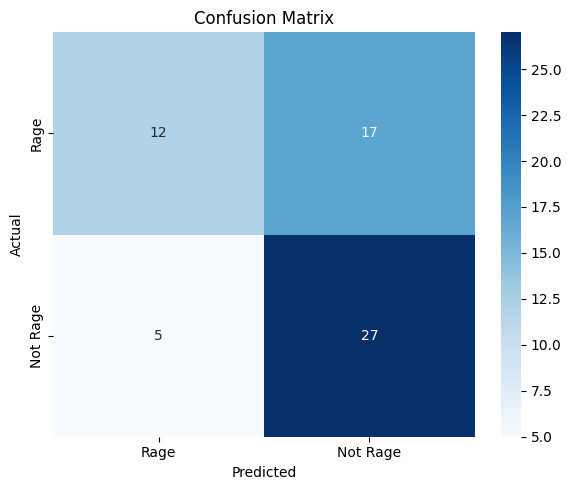

Evaluation metrics with both classses:
              precision    recall  f1-score   support

           0       0.71      0.41      0.52        29
           1       0.61      0.84      0.71        32

    accuracy                           0.64        61
   macro avg       0.66      0.63      0.62        61
weighted avg       0.66      0.64      0.62        61



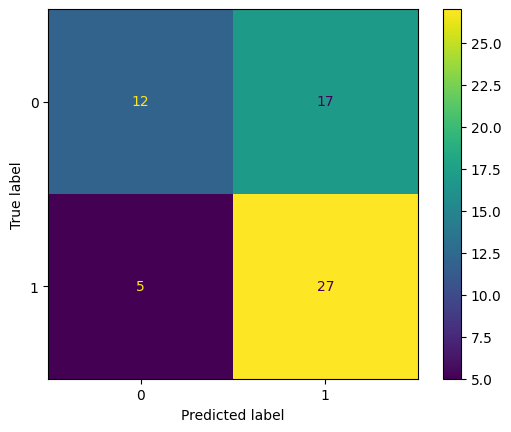

In [9]:
evaluate_model(video_model, audio_model, fusion_model, dataloader, device)